# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import lightgbm as lgb
import random

In [2]:
# garbage collection
import gc
gc.enable()

In [3]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [5]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under"

In [6]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [7]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under_wlp_lm_bm"

In [8]:
# drop high recency from train
#data = data[(data.Week == 121) | (data.Recency2 < 27)]
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]
data.shape

(2668912, 45)

# 3. PREPARATIONS

### ADD MORE FEATURES

In [9]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1
print(data.shape)

(2668912, 45)


In [10]:
### RF Ratios

#data["R12_ratio"] = data.Recency1 / data.Recency2
#data["R13_ratio"] = data.Recency1 / data.Recency3
#data["R14_ratio"] = data.Recency1 / data.Recency4
#data["R56_ratio"] = data.Recency5 / data.Recency6

#data["F12_ratio"] = data.Frequency1 / data.Frequency2
#data["F13_ratio"] = data.Frequency1 / data.Frequency3
#data["F14_ratio"] = data.Frequency1 / data.Frequency4
#data["F56_ratio"] = data.Frequency5 / data.Frequency6

#data.shape

In [11]:
# add last week sum (CUST)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "Week", "LastWeekCustSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week sum (BOND)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["IsinIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "Week", "LastWeekBondSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "Week"])
print(data.shape)

(2668912, 46)
(2668912, 47)


In [12]:
### ADD PRICE AND NOTIONAL

tmp = pd.read_csv("../data/prepared/price_notional.csv", compression = "gzip")

# add last week price sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.Price.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustPriceSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week notional sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.NotionalEUR.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustNotionalSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

(2668912, 48)
(2668912, 49)


In [13]:
### ADD CUSTOMER INDICATORS

#cust  = pd.read_csv("../data/raw/Customer.csv")
#cust.head()

# create dummies for customers
#cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Subsector)], axis = 1)

# merge customer dummies
#data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")
#print(data.shape)

In [14]:
### ADD BOND FEATURES [V1]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", "t", "timeOnMarket", "percentoflifeleft"]], how = "left", on = "IsinIdx")
#print(data.shape)

In [15]:
### ADD NEW BOND FEATURES [V2]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat2_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'ymeansq', 'ymeancube', 'zmeansq', 'zmeancube',
#                             'years_tomaturity', 'count', 'ratingspread', 'ratingZspread']], 
#                  how = "left", on = "IsinIdx")
#print(data.shape)

In [16]:
### ADD BOND FEATURES [V3]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat3_AK")
#bond_stat.head()

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'predyield', 'predprice']], how = "left", on = "IsinIdx")
#print(data.shape)

In [17]:
### BOND-SPECIFIC FINANCIAL INDICATORS

#bond  = pd.read_csv("../data/raw/Isin.csv")

# create bond dummies
#bond_dummies = pd.concat([bond.IsinIdx,
#                          pd.get_dummies(bond.IndustrySector), 
#                          pd.get_dummies(bond.Region),
#                          pd.get_dummies(bond.MarketIssue), 
#                          pd.get_dummies(bond.CouponType)], axis = 1)

# merge bond dummies
#data = data.merge(bond_dummies, on = "IsinIdx", how = "left")
#print(data.shape)

In [18]:
### ADD NEW NIKITA FEATURES

# import data
#cust    = pd.read_csv("../data/prepared/cust_nik.csv",   compression = "gzip")
#bond    = pd.read_csv("../data/prepared/bond_nik.csv",   compression = "gzip")
#market  = pd.read_csv("../data/prepared/market_nik.csv", compression = "gzip")

#cust = cust[["CustomerIdx", "Region"]]
#bond = bond[["IsinIdx", "ActualMaturityDateKey", "IssueDateKey"]]

# merge data
#print(data.shape)
#data = data.merge(cust, on = "CustomerIdx", how = "left")
#print(data.shape)
#data = data.merge(bond, on = "IsinIdx", how = "left")
#print(data.shape)
#data = data.merge(market, on = ["IsinIdx", "Week"], how = "left")
#print(data.shape)

# compute day differences
#data["ActualMaturityDateKey"] = data["ActualMaturityDateKey"] - data["Week"]
#data["IssueDateKey"]          = data["IssueDateKey"] - data["Week"]

In [19]:
### ADD LAST MONTH SUMS

# merge month number
tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# add last month mean (CUST)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["CustomerIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "CumMonth", "LastMonthCustSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "CumMonth"])
print(data.shape)

# add last month mean (BOND)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["IsinIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "CumMonth", "LastMonthBondSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "CumMonth"])
print(data.shape)

# drop month
del data["CumMonth"]

(2668912, 51)
(2668912, 52)


In [20]:
### ADD BOND MATURITY DATA

# import
bond = pd.read_csv("../data/prepared/data_bond_v1.csv", compression = "gzip")
bond = bond[['IsinIdx', 'MaturityWeek', 'IssueWeek']]

# merge
data = data.merge(bond, on = "IsinIdx", how = "left")

# compute week differences
data["MaturityWeek"]    = data.MaturityWeek - data.Week
data["IssueWeek"]       = data.Week - data.IssueWeek
data["MaturityPercent"] = (data.Week - data.IssueWeek) / (data.MaturityWeek - data.IssueWeek)
print(data.shape)

(2668912, 54)


In [21]:
### MERGE WEEKLY MACRO VARIABLES

# import
#fx1   = pd.read_csv("../data/prepared/data_fx1_v1.csv",  compression = "gzip")
#fx2   = pd.read_csv("../data/prepared/data_fx2_v1.csv",  compression = "gzip")
#ind1  = pd.read_csv("../data/prepared/data_ind1_v1.csv", compression = "gzip")
#ind2  = pd.read_csv("../data/prepared/data_ind2_v1.csv", compression = "gzip")

# merge currency
#bond = pd.read_csv("../data/raw/Isin.csv")
#data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")

# merge macro data
#data = data.merge(fx1,  how = 'left', on = ["Week",  "Currency"])
#print(data.shape)
#data = data.merge(fx2,  how = 'left', on = ["Month", "Currency"])
#print(data.shape)
#data = data.merge(ind1, how = 'left', on = "Week")
#print(data.shape)
#data = data.merge(ind2, how = 'left', on = "Month")
#print(data.shape)

# there are a few currencies for which we don't have info, e.g. CNH
#data[fx1.columns] = data[fx1.columns].fillna(0)
#data[fx2.columns] = data[fx2.columns].fillna(0)

# remove currency
#data.drop("Currency", axis = 1, inplace = True)
#print(data.shape)

In [22]:
### ADD NEW WEEKLY AND MONTHLY MARKET FEATURES

# merge month number
'''tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# import data
market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")
market = market.rename(columns = {"Month": "CumMonth"})
market.CumMonth = market.groupby(["IsinIdx", "Week"]).CumMonth.min()
keep = market[["IsinIdx", "Week", "CumMonth"]].drop_duplicates().index
market = market[market.index.isin(keep)]
data = data.merge(market, how = "left", on = ["IsinIdx", "Week", "CumMonth"])
del data["CumMonth"]
print(data.shape)'''

'tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]\ntmp = tmp.drop_duplicates()\ntmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = \'%Y%m%d\')\ntmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)\ntmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)\ntmp = tmp[["Week", "CumMonth"]]\ntmp = tmp.drop_duplicates()\ntmp = tmp.groupby("Week").CumMonth.min().reset_index()\ndata = data.merge(tmp, how = "left", on = "Week")\ndata["CumMonth"][data.Week == 121] = 28\n\n# import data\nmarket  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")\nmarket = market.rename(columns = {"Month": "CumMonth"})\nmarket.CumMonth = market.groupby(["IsinIdx", "Week"]).CumMonth.min()\nkeep = market[["IsinIdx", "Week", "CumMonth"]].drop_duplicates().index\nmarket = market[market.index.isin(keep)]\ndata = data.merge(market, how = "left", on = ["IsinIdx", "Week", "CumMonth"])\ndel data["CumMonth"]\nprin

### CHECKS AND PREPARATIONS

In [23]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (2668912, 54)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta,LastWeekCustSum,LastWeekBondSum,LastWeekCustPriceSum,LastWeekCustNotionalSum,LastMonthCustSum,LastMonthBondSum,MaturityWeek,IssueWeek,MaturityPercent
0,NaN,2554,12022,Sell,0.0,68,2.0,2.0,1.0,1.0,2.0,2.0,1,0,0.014925,0.029851,43.716418,80.791045,0.134328,0.208955,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1.00000,117.319623,4.613998,4.468827,0.354249,2.207733,0.545221,1.418700,0.584150,27.0,0.0,5.224483e+03,7.224512e+07,173.0,1.0,930,630,-1.873333
1,NaN,1997,23143,Sell,0.0,112,71.0,71.0,1.0,1.0,1.0,1.0,1,0,0.009009,0.009009,4.333333,6.252252,0.990991,2.315315,1,1,3,0,0,1,0,0,0,0,0,1,1,0,0,0,-0.00752,102.526643,8.867004,2.470258,2.011795,2.344190,1.979572,-0.579869,0.720607,0.0,5.0,1.000099e+06,1.400000e+06,14.0,7.0,202,161,-1.195122
2,NaN,2743,5570,Buy,0.0,99,88.0,88.0,1.0,1.0,6.0,4.0,1,0,0.020408,0.020408,62.642857,106.000000,0.775510,1.387755,1,1,5,1,1,0,0,0,0,0,0,1,1,0,0,0,1.00000,102.627270,2.228127,3.838438,0.347182,1.876163,0.581684,0.788311,0.252580,57.0,0.0,9.977553e+03,1.362031e+08,441.0,2.0,359,161,-0.313131
3,NaN,1307,23023,Buy,0.0,91,82.0,82.0,1.0,1.0,20.0,2.0,1,0,0.011111,0.011111,1.288889,2.233333,0.500000,0.977778,1,1,7,1,0,0,1,0,0,0,0,1,1,0,0,0,-0.00294,101.017280,0.204407,-0.036528,0.193049,0.161060,0.150582,-3.086655,-1.462523,1.0,0.0,5.227220e+02,3.768715e+06,2.0,0.0,60,148,0.647727
4,NaN,2107,5204,Sell,0.0,73,2.0,2.0,1.0,1.0,1.0,1.0,1,0,0.027778,0.027778,9.500000,21.541667,0.319444,0.777778,1,1,12,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,110.170463,2.443280,5.958544,0.341985,3.637930,0.340257,2.908417,2.014346,3.0,4.0,5.547505e+03,3.071459e+07,27.0,1.0,464,6,0.146288


In [24]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx              2184154
CustomerInterest            484758
MeanPrice                   206495
StdPrice                    206601
MeanYield                   206495
StdYield                    206601
MeanZScore                  206495
StdZScore                   206601
YieldMarktDelta             206495
ZScoreMarktDelta            206495
LastWeekCustSum              53095
LastWeekBondSum             439429
LastWeekCustPriceSum        163874
LastWeekCustNotionalSum     159194
LastMonthCustSum             32568
LastMonthBondSum            122039
MaturityPercent                  3
dtype: int64

In [25]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
col_with_na = ['MeanPrice', 'StdPrice',
       'MeanYield', 'StdYield', 'MeanZScore', 'StdZScore', 'YieldMarktDelta',
       'ZScoreMarktDelta']
col_zero =  ['LastWeekCustSum', 'LastWeekBondSum',
       'LastWeekCustPriceSum', 'LastWeekCustNotionalSum', 'LastMonthCustSum',
       'LastMonthBondSum', 'MaturityPercent']

In [27]:
for col in col_with_na:
    data[col].fillna(np.mean(data[col]), inplace=True)
    
for col in col_zero:
    data[col].fillna(np.mean(data[col]), inplace=True)

In [28]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest",
                     "Frequecny1isLowerFrequency2", "Frequecny2isLowerFrequency4"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

47

In [29]:
### DATA PARTITIONING

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

In [30]:
# check NA in test
nas = test.isnull().sum()
nas[nas > 0]

CustomerInterest    484758
dtype: int64

In [31]:
nas = X_valid.isnull().sum()
nas[nas > 0]

PredictionIdx    40437
dtype: int64

# 4. MODELING - STAGE 1

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

In [58]:
num_iters=1000

In [59]:
rf = ExtraTreesClassifier(n_estimators=num_iters, n_jobs=16, verbose=1)

In [60]:
rf.fit(X_train[features], y_train)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   33.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  7.9min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 14.4min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed: 18.7min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=16,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [63]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = rf.predict_proba(X_valid[features])[:,1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_exdt.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = rf.predict_proba(test[features])[:,1]

# export CSV
subm = test[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_exdt_1stage.csv", 
            index = False, float_format = "%.8f")

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   10.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   19.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   24.8s finished


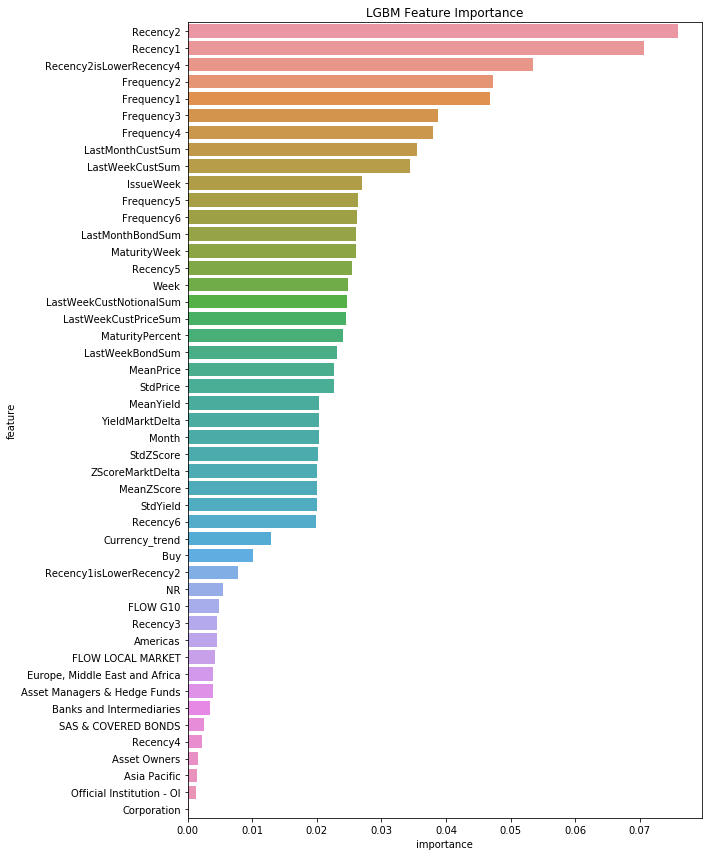

In [64]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = rf.feature_importances_
%matplotlib inline
# plot variable importance
plt.figure(figsize = (10, 12))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title("LGBM Feature Importance")
plt.tight_layout()

# save plot as pdf
#plt.savefig(“../var_importance.pdf)

# 5. MODELING - STAGE 2

In [65]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

In [ ]:
rf = ExtraTreesClassifier(n_estimators=num_iters,  max_depth=None, min_samples_leaf=2, max_features='auto', n_jobs=10, verbose=1)
rf.fit(X_train[features], y_train)

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   41.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 18.2min


In [ ]:
# predict test set
test["TARGET"] = rf.predict_proba(test[features])[:, 1]

In [ ]:
# export CSV
subm = test[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_exdt_2stage.csv", 
            index = False, float_format = "%.8f")